In [2]:
import numpy as np
import math
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
EPSILON = 1e-12

## Class ACTIVATIONS

In [4]:
class sigmoid():
    @staticmethod
    def activation(x):
        y = 1 / (1 + np.exp(-x))
        return y
    @staticmethod
    def prime(y):
        f = sigmoid.activation(y)
        return (f * (1 - f))

In [280]:
class softmax:
    @staticmethod
    def activation(x):
        # e_x = np.exp(x).reshape(-1,1)
        e_x = np.exp(x - np.max(x,axis=-1).reshape(-1,1))
        return e_x / e_x.sum(axis=-1).reshape(-1,1)
    @staticmethod
    def prime(y):
        n=y.shape[-1]
        SM = y.reshape((-1,n))
        print(SM)
        jac = np.diagflat(y) - np.dot(SM, SM.T)
        return jac
    @staticmethod
    def primeA(y):
        return(y * (1-y))

In [269]:
print(a)
print(softmax.primeP(a))

[[0.09003057 0.66524096 0.24472847]
 [0.66524096 0.09003057 0.24472847]]


AttributeError: type object 'softmax' has no attribute 'primeP'

In [231]:
def Softmax(x):
    '''
    Performs the softmax activation on a given set of inputs
    Input: x (N,k) ndarray (N: no. of samples, k: no. of nodes)
    Returns: 
    Note: Works for 2D arrays only(rows for samples, columns for nodes/outputs)
    '''
    max_x = np.amax(x, 1).reshape(x.shape[0],1) # Get the row-wise maximum
    e_x = np.exp(x - max_x ) # For stability
    return e_x / e_x.sum(axis=1, keepdims=True) 

In [232]:
def Softmax_grad(x): # Best implementation (VERY FAST)
    '''Returns the jacobian of the Softmax function for the given set of inputs.
    Inputs:
    x: should be a 2d array where the rows correspond to the samples
        and the columns correspond to the nodes.
    Returns: jacobian
    '''
    s = Softmax(x)
    a = np.eye(s.shape[-1])
    temp1 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    temp2 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    temp1 = np.einsum('ij,jk->ijk',s,a)
    temp2 = np.einsum('ij,ik->ijk',s,s)
    return temp1-temp2

## Class Loss Functions

In [233]:
class BinaryCrossEntropy:
    def __init__(self, p, y,_m,**kwargs):
        self.p = p
        self.y = y
        self.m = _m
        self.sw = kwargs.get('sample_weight',1)

    def normalized(self,a,y):
        self.p = a
        self.y = y
        self.c = self.y.shape[-1] #nb de class
    def metrics(self):
        r = (1 / self.m) * np.sum(self.forward()) /self.c
        return r
    def forward(self):
    # (-y.log(p) - (1-y).log(1-p))
        f = ((-self.y * np.log(self.p + EPSILON)) - ((1 - self.y) * (np.log(1 - self.p + EPSILON)))) * self.sw
        return f
    def backward(self):
    # -y/p + (1-y)/(1-p)
        # n = self.p.shape[0]
        return (-self.y/(self.p + EPSILON) + (1 - self.y)/(1 - self.p + EPSILON)) * self.sw

In [234]:
class CategoricalCrossEntropy():
    def __init__(self, a, y_true , _m, **kwargs):
        self.p = a / (np.sum(a,axis=-1,keepdims=True)+EPSILON)
        self.y = y_true
        self.m = _m
        self.sw = kwargs.get('sample_weight',1)
    def normalized(self,a,y_true):
        self.p = a / (np.sum(a,axis=-1,keepdims=True)+EPSILON)
        self.y = y_true
        # self.c = self.y.shape[-1] #nb de class
    def metrics(self): # -y.log(p)
        return (1 / self.m) * np.sum(self.forward())
    def forward(self): # -y.log(p)
        return (-self.y * np.log(self.p+EPSILON)) * self.sw
    def backward(self): # -y/p
        return (-self.y/(self.p+EPSILON)) * self.sw

In [235]:
class MSE():
    def __init__(self, p, y, _m, **kwargs):
        self.p = p
        self.y = y
        self.m = _m
        self.sw = kwargs.get('sample_weight',1)
    def normalized(self,a,y):
        self.p = a
        self.y = y
        self.c = self.y.shape[-1] #nb de class
    def forward(self):
        return (np.square(self.p - self.y)) / self.c * self.sw
    def backward(self):
        return (2*(self.p - self.y)) * self.sw
    def metrics(self):
        return (1 / self.m) * (np.sum(self.forward()))
        # return 1/self.m *np.sum(np.square(self.p - self.y))

## JEUX DE TEST 
* y : valeur TRUE
* z : simulation valeur sortie couche z = wX + b
* a : résultat couche activation SOFTMAX

In [236]:
np.random.seed(120)
y = np.array([[0,0,0,0,1,0,0,0,0,0]])
z = np.random.randn(1,10)/np.sqrt(2/10)
a = softmax.activation(z)
# a = Softmax(z)
# print(a)
print(z,a,a.sum(axis=-1))

[[ 0.32970771  4.52768052 -0.95453353  5.16596603  1.40572632 -0.1239037
  -2.95130235  0.90576774 -0.41480254 -0.22734566]] [[4.99355964e-03 3.32327797e-01 1.38251979e-03 6.29173675e-01
  1.46460052e-02 3.17255608e-03 1.87709251e-04 8.88361913e-03
  2.37177533e-03 2.86078379e-03]] [1.]


In [237]:
a2 = Softmax(z)
print(a2,a2.sum(axis=-1))

[[4.99355964e-03 3.32327797e-01 1.38251979e-03 6.29173675e-01
  1.46460052e-02 3.17255608e-03 1.87709251e-04 8.88361913e-03
  2.37177533e-03 2.86078379e-03]] [1.]


In [238]:
L = CategoricalCrossEntropy(a,y,1)
L.normalized(a,y)
l = L.metrics()
print(l)
dL_da = L.backward()
da_dz = softmax.prime(a)
diff = dL_da * da_dz
print(dL_da)
print(diff,y.shape)
print(da_dz)
print(a-y)

4.223587661845474
(10, 1)
[[  0.           0.           0.           0.         -68.27800379
    0.           0.           0.           0.           0.        ]]
[[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   4.99355964e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   3.32327797e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   1.38251979e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   6.29173675e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -9.85353995e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-

In [240]:
da_dz_2 = Softmax_grad(a).reshape(10,10)
print(da_dz_2,dL_da)
dz = (da_dz_2 @ dL_da.T)
# print(dz.sum(axis=0))
# dz = dz / np.sum(dz)
print(dz)

[[ 0.0809707  -0.01095602 -0.0078691  -0.01474251 -0.00797417 -0.0078832
  -0.00785971 -0.00792835 -0.00787689 -0.00788074]
 [-0.01095602  0.10808494 -0.01091653 -0.02045177 -0.01106229 -0.01093609
  -0.0109035  -0.01099873 -0.01092734 -0.01093268]
 [-0.0078691  -0.01091653  0.08070721 -0.01468937 -0.00794543 -0.00785479
  -0.00783138 -0.00789977 -0.0078485  -0.00785234]
 [-0.01474251 -0.02045177 -0.01468937  0.13837166 -0.0148855  -0.01471569
  -0.01467183 -0.01479997 -0.01470391 -0.0147111 ]
 [-0.00797417 -0.01106229 -0.00794543 -0.0148855   0.08167871 -0.00795966
  -0.00793594 -0.00800525 -0.00795329 -0.00795718]
 [-0.0078832  -0.01093609 -0.00785479 -0.01471569 -0.00795966  0.08083773
  -0.00784541 -0.00791393 -0.00786256 -0.00786641]
 [-0.00785971 -0.0109035  -0.00783138 -0.01467183 -0.00793594 -0.00784541
   0.08062019 -0.00789034 -0.00783913 -0.00784296]
 [-0.00792835 -0.01099873 -0.00789977 -0.01479997 -0.00800525 -0.00791393
  -0.00789034  0.0812554  -0.00790759 -0.00791146]
 

In [241]:
# Vérification CCE
f_cce = CategoricalCrossEntropy(a,y,1)
f_cce.normalized(a,y)
e1 = f_cce.metrics()
t_tf = tf.nn.softmax(z)
t_cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
t1 = t_cce(y,t_tf).numpy()
print('ep cce:', e1)
print('tf cce:',t1)

ep cce: 4.223587661845474
tf cce: 4.2235876619127515


In [242]:
t_tf = tf.nn.softmax(z)
print(t_tf)

tf.Tensor(
[[4.99355964e-03 3.32327797e-01 1.38251979e-03 6.29173675e-01
  1.46460052e-02 3.17255608e-03 1.87709251e-04 8.88361913e-03
  2.37177533e-03 2.86078379e-03]], shape=(1, 10), dtype=float64)


In [243]:
t_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
t = t_bce(y,t_tf).numpy()
print('ep bce:', l)
print('tf bce:', t)

ep bce: 4.223587661845474
tf bce: 0.5643476765841015


## Vérification metrics Binary Cross Entropy
* EPSILON = 1e-12
* utilisation sample_weight

In [244]:
y_true = np.array([[0, 1], [0, 0]])
y_pred = np.array([[-18.6, 0.51], [2.94, -12.8]])
sw = np.array([[0.8],[0.2]])
ypS = sigmoid.activation(y_pred)
# yp = np.clip(y_pred,1e-8,1e8)
bce = BinaryCrossEntropy(ypS,y_true,2,sample_weight = sw)
bce.normalized(ypS,y_true)
bce_f = (bce.forward())
print(np.mean(bce_f))
l_bce = bce.metrics()
print('ep:',l_bce)
t_bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print('tf:',t_bce(y_true,y_pred,sample_weight=sw).numpy())

0.24363858891514345
ep: 0.24363858891514345
tf: 0.24363858891670923


## Vérification metrics Categorical Cross Entropy

In [245]:
y_true = np.array([[0, 1], [0, 0]])
y_pred = np.array([[-1.6, 0.51], [-1.94, -1.8]])
sw = np.array([[0.8],[0.2]])
ypS = sigmoid.activation(y_pred)
t_ypS = tf.nn.sigmoid(y_pred)
# print(t_ypS,ypS)
t2_cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
t2 = t2_cce(y_true,t_ypS,sample_weight=sw).numpy()
print('tf:',t2)
e2_cce = CategoricalCrossEntropy(t_ypS,y_true,2,sample_weight=sw)
e2_cce.normalized(t_ypS,y_true)
e2 = e2_cce.metrics()
print('ep:',e2)

tf: 0.09524559936875954
ep: 0.09524559936875655


## Vérification MSE

In [246]:
t_mse = tf.keras.losses.MeanSquaredError()
tf_mse = t_mse(y_true,t_ypS).numpy()
print('tf:',tf_mse)
f_mse = MSE(t_ypS,y_true,2)
f_mse.normalized(t_ypS,y_true)
ep_mse = f_mse.metrics()
print('ep:',ep_mse)

tf: 0.051224278248531804
ep: 0.051224278248531804


In [247]:
# x = (np.arange(0,10).reshape((10,1)) - 5 ) /10
x = np.random.randn(10,2)
# print(x)
s = softmax()
s_x = s.activation(x)
print(s_x)

[[0.6073398  0.3926602 ]
 [0.63527268 0.36472732]
 [0.29981797 0.70018203]
 [0.5197816  0.4802184 ]
 [0.9374528  0.0625472 ]
 [0.14825149 0.85174851]
 [0.67990632 0.32009368]
 [0.33172482 0.66827518]
 [0.216663   0.783337  ]
 [0.75193927 0.24806073]]


In [248]:
# Tensorflow
X_tf = tf.convert_to_tensor(x, dtype=tf.float32)
# print(X_tf)
softmax_tf_value = tf.keras.activations.softmax(X_tf)
print(softmax_tf_value.numpy())

[[0.60733986 0.3926602 ]
 [0.6352727  0.3647273 ]
 [0.29981798 0.7001821 ]
 [0.51978165 0.48021844]
 [0.9374528  0.06254719]
 [0.14825149 0.8517485 ]
 [0.6799063  0.32009363]
 [0.33172482 0.66827524]
 [0.21666296 0.783337  ]
 [0.75193936 0.24806073]]


In [249]:
# Tensorflow
time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
# ep
time = %timeit -n 100 -o softmax.activation(x)
# autre
time = %timeit -n 100 -o Softmax(x)
# tf
time = %timeit -n 100 -o tf.nn.softmax(x)

59.4 µs ± 8.39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.86 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.44 µs ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
478 µs ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [250]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob.numpy()

In [305]:
class softmax_tf_ep:
    @staticmethod
    def activation(x):
        # e_x = np.exp(x).reshape(-1,1)
        e_x = tf.math.exp(x - tf.reshape(tf.reduce_max(x,axis=-1),[-1,1]))
        return e_x / tf.reshape(tf.reduce_sum(e_x,axis=-1),[-1,1])
    @staticmethod
    def prime(y):
        n=y.shape[-1]
        SM = y.reshape((-1,n))
        print(SM)
        jac = np.diagflat(y) - np.dot(SM, SM.T)
        return jac
    @staticmethod
    def primeA(y):
        return(y * (1-y))

In [306]:
def ep_softmax_grad(z):
    # z = tf.convert_to_tensor(x, dtype=tf.float32)
    z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = softmax_tf_ep.activation(z)
        # b = tf.convert_to_tensor(a, dtype=tf.float32)
        a = tf.constant(a, dtype=tf.float32)
    jacob = g.batch_jacobian(a, z)
    return jacob.numpy()

In [307]:
print(ep_softmax_grad(x))

2023-01-05 23:34:40.001175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[[ 0.2384782  -0.2384782 ]
  [-0.23847817  0.23847817]]

 [[ 0.23170127 -0.23170127]
  [-0.23170128  0.23170128]]

 [[ 0.20992716 -0.20992716]
  [-0.20992717  0.20992717]]

 [[ 0.24960873 -0.24960873]
  [-0.24960867  0.24960867]]

 [[ 0.05863504 -0.05863504]
  [-0.05863504  0.05863504]]

 [[ 0.12627299 -0.12627299]
  [-0.12627299  0.12627299]]

 [[ 0.21763368 -0.21763368]
  [-0.21763371  0.21763371]]

 [[ 0.22168347 -0.22168347]
  [-0.22168349  0.22168349]]

 [[ 0.16972013 -0.16972013]
  [-0.16972011  0.16972011]]

 [[ 0.18652664 -0.18652664]
  [-0.18652661  0.18652661]]]


In [253]:
g =Softmax_grad(s_x)
print(g.shape)
print(g[0])

(10, 2, 2)
[[ 0.24714152 -0.24714152]
 [-0.24714152  0.24714152]]


In [255]:
print(tf_softmax_grad(softmax_tf_value)[0])

[[ 0.24714153 -0.2471415 ]
 [-0.2471415   0.24714153]]


2023-01-04 23:26:45.397411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [257]:
print(softmax.prime(s_x[0]))

(2, 1)
[[ 0.23847817 -0.23847817]
 [-0.23847817  0.23847817]]


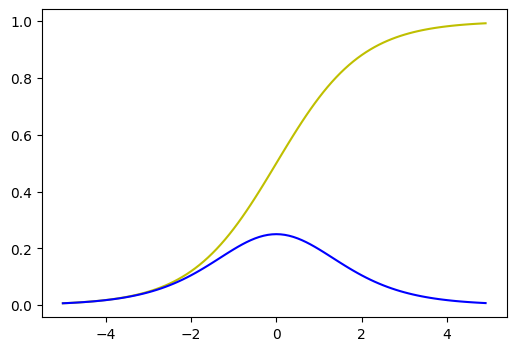

In [413]:
x = np.arange(-5,5,0.1)
np.random.seed(120)
# x = np.random.randn(100,3)
# f_x = 2 *x ** 2 + 4*x + 5
# f_x = softmax.activation(x)
f_x = sigmoid.activation(x)
# fp_x = 4*x + 4
fp_x = sigmoid.prime(x)
fig = plt.figure(figsize=(6,4))
plt.plot(x,f_x,c='y')
plt.plot(x,fp_x,c='b')
# plt.scatter([1],[11],[33],c='r')
# plt.plot([0,1,2],[3,11,19],c='b')
plt.show()

# Test Softmax et Categorical Loss Entropy

In [281]:
y = np.array([[0,1,0],[1,0,0]])
z = np.array([[1,3,2],[3,1,2]])
a = Softmax(z)
L_fct = CategoricalCrossEntropy(a,y,1)
L_fct.normalized(a,y)
loss = L_fct.metrics()

In [282]:
print(a)
print(loss)
print('target: ', a-y)

[[0.09003057 0.66524096 0.24472847]
 [0.66524096 0.09003057 0.24472847]]
0.8152119288877543
target:  [[ 0.09003057 -0.33475904  0.24472847]
 [-0.33475904  0.09003057  0.24472847]]


In [283]:
dL = L_fct.backward()
print(dL)
g =softmax.prime(a)
print(a.shape)
print(g.reshape(a.shape[0],a.shape[1],a.shape[1]))
print((g @ dL.T).T)

[[ 0.         -1.50321472  0.        ]
 [-1.50321472  0.          0.        ]]
[[0.09003057 0.66524096 0.24472847]
 [0.66524096 0.09003057 0.24472847]]


ValueError: operands could not be broadcast together with shapes (6,6) (2,2) 

In [258]:
g = Softmax_grad(a)
print(g)
print(softmax.prime(a))
z_tf = tf.convert_to_tensor(z, dtype=tf.float32)
tf_a = tf.keras.activations.softmax(z_tf)
print(tf_softmax_grad(tf_a))
print(softmax.prime(a))

[[[ 0.0809707  -0.01095602 -0.0078691  -0.01474251 -0.00797417
   -0.0078832  -0.00785971 -0.00792835 -0.00787689 -0.00788074]
  [-0.01095602  0.10808494 -0.01091653 -0.02045177 -0.01106229
   -0.01093609 -0.0109035  -0.01099873 -0.01092734 -0.01093268]
  [-0.0078691  -0.01091653  0.08070721 -0.01468937 -0.00794543
   -0.00785479 -0.00783138 -0.00789977 -0.0078485  -0.00785234]
  [-0.01474251 -0.02045177 -0.01468937  0.13837166 -0.0148855
   -0.01471569 -0.01467183 -0.01479997 -0.01470391 -0.0147111 ]
  [-0.00797417 -0.01106229 -0.00794543 -0.0148855   0.08167871
   -0.00795966 -0.00793594 -0.00800525 -0.00795329 -0.00795718]
  [-0.0078832  -0.01093609 -0.00785479 -0.01471569 -0.00795966
    0.08083773 -0.00784541 -0.00791393 -0.00786256 -0.00786641]
  [-0.00785971 -0.0109035  -0.00783138 -0.01467183 -0.00793594
   -0.00784541  0.08062019 -0.00789034 -0.00783913 -0.00784296]
  [-0.00792835 -0.01099873 -0.00789977 -0.01479997 -0.00800525
   -0.00791393 -0.00789034  0.0812554  -0.0079075

2023-01-04 23:28:49.750664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [217]:
a0 = a[0][0]
a1 = a[0][1]
a2 = a[0][2]
print(a[0][0], a[0][1])
print(a0*(1-a0))
print(a1*(1-a1))
print(a2*(1-a2))
print(-a1*a0)
print(-a0*a2)

0.09003057317038046 0.6652409557748218
0.08192506906499324
0.2226954265346234
0.1848364465099787
-0.05989202454481893
-0.022033044520174298
